# Fine Tune Vision Transformer for Food Classification
* Notebook by Adam Lang
* Date: 1/10/2024

# Overview
* In this notebook we will fine tune a Vision Transformer (ViT) for image classification on a food dataset.

# Fine Tuning Vision Transformers
* This is based off the original vision transformers paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"
  * link to paper: https://arxiv.org/abs/2010.11929


# Dataset
* You can use any image labeled dataset that you choose.
* The dataset for this project is open source from hugging face.
* There are 20 class labels and over 5,000 rows of pictures.
```
Classes of the model:
"burger",
"butter_naan",
"chai",
"chapati",
"chole_bhature",
"dal_makhani",
"dhokla",
"fried_rice",
"idli",
"jalebi",
"kaathi_rolls",
"kadai_paneer",
"kulfi",
"masala_dosa",
"momos",
"paani_puri",
"pakode",
"pav_bhaji",
"pizza",
"samosa"
```
* dataset card: https://huggingface.co/datasets/rajistics/indian_food_images

# Install Dependencies

In [1]:
%%capture
!pip install datasets
!pip install -U datasets
!pip install evaluate

In [2]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import Modules

In [42]:
## Standard DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

## other imports
import requests
from PIL import Image
from io import BytesIO

## ML imports
import torch
import torchvision
import evaluate ## metrics for evaluation
import transformers
from transformers import(
    AutoImageProcessor, # image tokenizer
    AutoModelForImageClassification, # classification head
    TrainingArguments, # fine-tuning
    Trainer, # fine-tuning
    pipeline, # inference
)
from datasets import load_dataset, Dataset, DatasetDict ## HF dataset, dataloaders
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

# Load Dataset from Hugging Face


In [4]:
## datasets from huggingface
food_data = load_dataset('rajistics/indian_food_images')

README.md:   0%|          | 0.00/660 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

(…)-00000-of-00001-dbae6752a5d31c49.parquet:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)-00000-of-00001-899c7c7e401d279b.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

# Explore the Data

In [5]:
## food
food_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

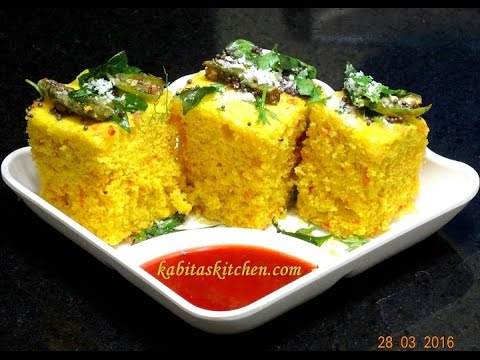

In [6]:
## lets see an image
food_data['train'][0]['image'] ## class id --> 6

In [7]:
## feature labels
labels = food_data['train'].features['label'].names
labels[6]

'dhokla'

## Labels and Ids
* Before we go any further, just as with any transformer based classification task, we need to link the label2id and id2label before proceeding.

In [8]:
## label2id and id2label configs
labels = food_data['train'].features['label'].names
label2id, id2label = dict(), dict() ## convert both to dicts

## loop over and assign label and ids
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

## print result
print(label2id)
print(id2label)

{'burger': 0, 'butter_naan': 1, 'chai': 2, 'chapati': 3, 'chole_bhature': 4, 'dal_makhani': 5, 'dhokla': 6, 'fried_rice': 7, 'idli': 8, 'jalebi': 9, 'kaathi_rolls': 10, 'kadai_paneer': 11, 'kulfi': 12, 'masala_dosa': 13, 'momos': 14, 'paani_puri': 15, 'pakode': 16, 'pav_bhaji': 17, 'pizza': 18, 'samosa': 19}
{0: 'burger', 1: 'butter_naan', 2: 'chai', 3: 'chapati', 4: 'chole_bhature', 5: 'dal_makhani', 6: 'dhokla', 7: 'fried_rice', 8: 'idli', 9: 'jalebi', 10: 'kaathi_rolls', 11: 'kadai_paneer', 12: 'kulfi', 13: 'masala_dosa', 14: 'momos', 15: 'paani_puri', 16: 'pakode', 17: 'pav_bhaji', 18: 'pizza', 19: 'samosa'}


In [9]:
food_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

Image shape: (360, 480, 3)


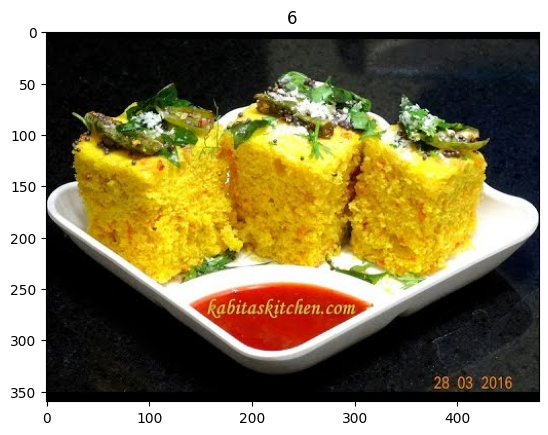

In [10]:
# create image and label
image = food_data['train'][0]['image']
label = food_data['train'][0]['label']

## convert image to numpy array to visualize
image_np = np.array(image)


print(f"Image shape: {image_np.shape}")
plt.imshow(image_np.squeeze()) # we need to use .squeeze to get rid of extra dimension for gray scale
plt.title(label);


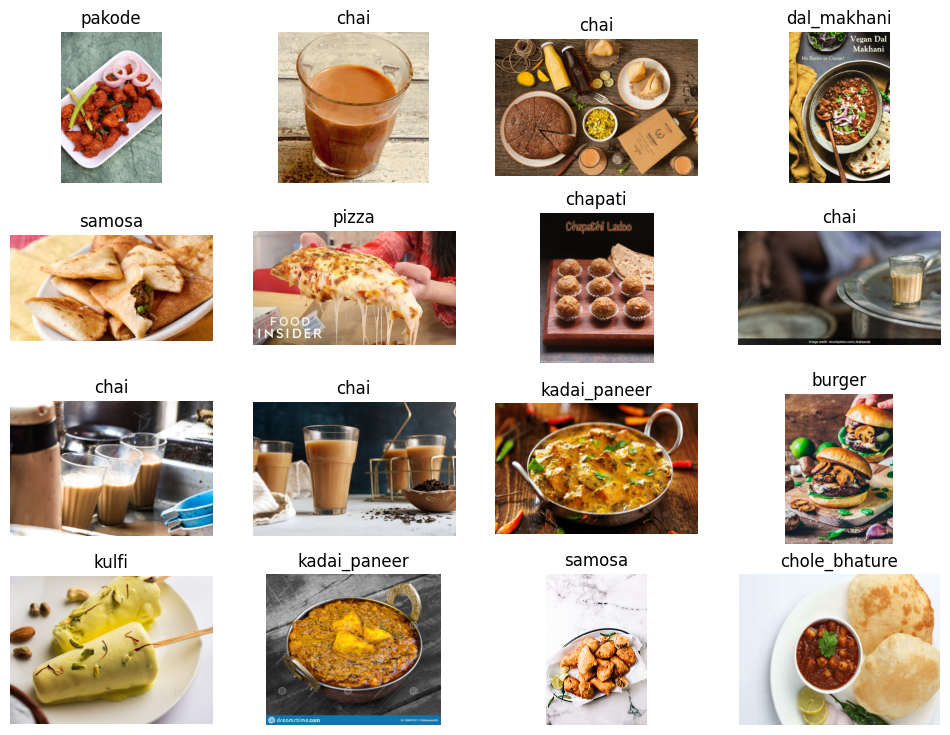

In [11]:
# plot more images - random images
#torch.manual_seed(42)
fig = plt.figure(figsize=(12,9))
rows, cols = 4, 4 # 4x4 grid
for i in range(1, rows*cols+1):
  # Get a random index from the 'train' split of the dataset.
  random_idx = torch.randint(0, len(food_data['train']), size=[1]).item()
  #print(random_idx) => this prints the indices
  # Access the image and label using the random index.
  img, label = food_data['train'][random_idx]['image'], food_data['train'][random_idx]['label']
  fig.add_subplot(rows, cols, i)
  # Convert the PIL Image to a NumPy array before using squeeze
  img_np = np.array(img)
  plt.imshow(img_np.squeeze(), cmap="gray") # use squeeze on the numpy array to remove dim 1
  # add labels
  plt.title(labels[label])
  plt.axis(False);

# Image Preprocessing and Evaluator Setup
* Similar to using a tokenizer for NLP, we can use an `AutoImageProcessor` which is based on the Torchvision library.
* More about the image processor classes:
  * https://huggingface.co/docs/transformers/main_classes/image_processor


* Model we are using 'google/vit-base-patch16-224-in21k`
  * model card: https://huggingface.co/google/vit-base-patch16-224-in21k

In [12]:
## load the model
model_ckpt = "google/vit-base-patch16-224-in21k"

## use `AutoImageProcessor` (tokenizes image)
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

## Preprocessing
* Images are in bytes, we need to convert them into pixel values for the vision transformer to process them.
* We also have to perform image normalization.
  * This is essential data augmentation such as "random crop", and some other augmentation techniques (e.g. flipping, rotation).
  * There is an entire library of torchvision transforms here: https://pytorch.org/vision/0.9/transforms.html

In [16]:
## lets see the image_processor
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [30]:
## RandomResizedCrop from torchvision
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor


## 1. Normailize images
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

## 2. Calculate image height --> RandomResizedCrop
## code logic: if the `size` is present in the image, then it will take that
## if not, then it will take the `shorted_edge`
size = (
    image_processor.size['shorted_edge']
    if "shorted_edge" in image_processor.size
    else (image_processor.size['height'], image_processor.size['width'])
)
## 3. Transform: RandomResizedCrop --> Tensors --> Normalize
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

## 4. Transform function
def transforms(examples):
  examples['pixel_values'] = [_transforms(img.convert('RGB')) for img in examples['image']]
  del examples['image']

  return examples

In [36]:
## apply transforms and update the dataset
food = food_data.map(transforms, batched=True, batch_size=16)

# Set the format to PyTorch tensors
food.set_format("torch", columns=["pixel_values"], output_all_columns=True)

Summary of above
* Mapping the Transform: Instead of using `with_transform`, which creates a view of the dataset with the transform applied but doesn't modify the underlying data, I've used the map function. The `.map` applies the function to the whole dataset and updates it in-place.
* If we do this instead of `.with_transform`, the data will be converted to tensors rather than holding the `JpegImageFile` object which the model can't process.

## Evaluate the Model

In [37]:
#import evaluate
#import numpy as np

## accuracy metric
accuracy = evaluate.load('accuracy')

## function for compute metrics
def compute_metrics(eval_pred):
  ## predictions are logits
  predictions, labels = eval_pred

  ## convert prediction logits to label indices
  predictions = np.argmax(predictions, axis=1)

  return accuracy.compute(predictions=predictions, references=labels)



# Vision Transformer (ViT) Fine Tuning

In [38]:
# from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
# import torch

## setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## load model with classification head
model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,

).to(device) ## send to GPU if available

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
## view model
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

Summary
* Patch embeddings --> uses convolutional layer to produce the embeddings ONLY.
* Embedding size 768 passed to encoder layer
* 12 encoder layers
* Intermediate layer uses GELUActivation
  * GELU is faster than RELU
  * GELU, stands for "Gaussian Error Linear Unit".
  * An activation function used in neural networks that weights inputs based on their probability under a Gaussian distribution, essentially acting like a smoother version of ReLU by considering the percentile of an input rather than just its sign.
  * it's often considered a high-performing activation function, particularly in large language models like BERT and GPT-3, due to its ability to **handle negative values more effectively than ReLU.**
* Output layer is classification head.

In [43]:
## setup training args
args = TrainingArguments(
    output_dir='train_dir',
    logging_steps=100, ## default is 500, with smaller dataset may not see loss
    remove_unused_columns=False, ## data passed into model will remove image col, set to False to avoid!
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4, ## every 4 batches update model weights
    num_train_epochs=4,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',


)

## init trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=food['train'],
    eval_dataset=food['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

## train model!
trainer.train()

TrainOutput(global_step=332, training_loss=1.2801507122545357, metrics={'train_runtime': 1165.7211, 'train_samples_per_second': 18.282, 'train_steps_per_second': 0.285, 'total_flos': 1.635654783678677e+18, 'train_loss': 1.2801507122545357, 'epoch': 3.960960960960961})

# Save Model

In [44]:
## save the model
trainer.save_model('food_classification_ViT')

# Inference on Fine-tuned model

In [47]:
# from transformers import pipeline
model_path = "/content/food_classification_ViT"
## init pipeline
pipe = pipeline('image-classification',
                model=model_path,
                device=device)

Device set to use cuda


## Inference #1 - non-indian food (pizza)

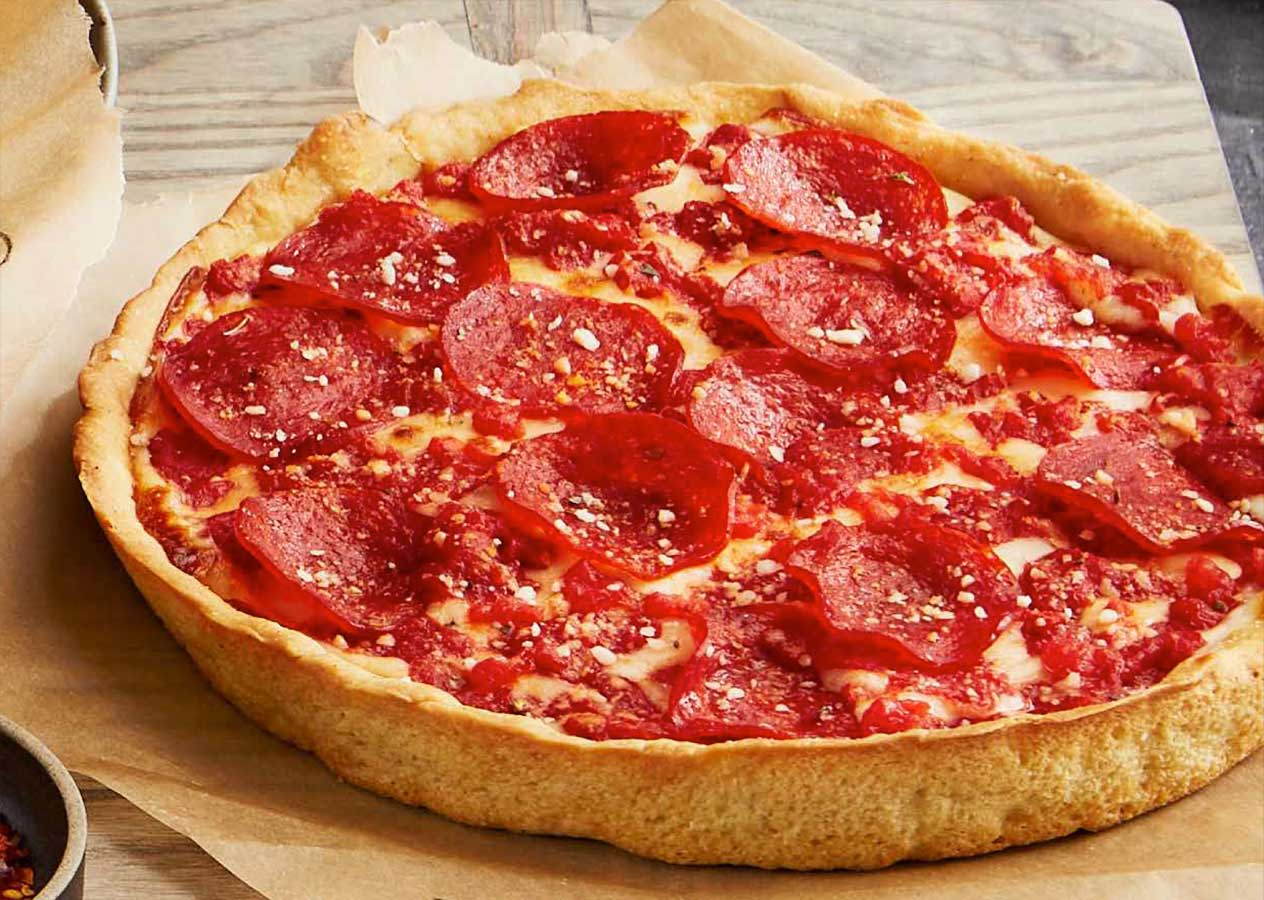

In [51]:
## lets pick a NON indian food to test the model
import requests
from PIL import Image
from io import BytesIO

## request image from url
image_url = "https://cdn11.bigcommerce.com/s-3xaaslonk2/images/stencil/original/image-manager/sausage-roni-main-image.jpg"
response = requests.get(image_url)
## open image
image = Image.open(BytesIO(response.content))

## display image
from IPython.display import display
display(image)


In [49]:
## now pass image to pipeline
pipe(image)

[{'label': 'pizza', 'score': 0.9894565939903259},
 {'label': 'pav_bhaji', 'score': 0.523680567741394},
 {'label': 'fried_rice', 'score': 0.49578484892845154},
 {'label': 'chole_bhature', 'score': 0.47968223690986633},
 {'label': 'butter_naan', 'score': 0.4772970378398895}]

Summary
* Great! The fine-tuned model was able to classify pizza which clearly this image is.
* Now lets try indian food to see if it can correctly classify that.

## Inference #2 - Indian food

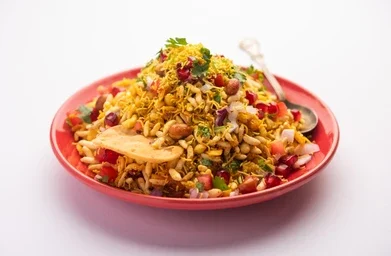

In [53]:
# request image from url
image_url = "https://thefamouscurrybazaar.co.uk/wp-content/uploads/2024/09/Jhal-Muri-e1726552500440.webp"
response = requests.get(image_url)
## open image
image = Image.open(BytesIO(response.content))

## display image
from IPython.display import display
display(image)


In [54]:
## test in pipeline
pipe(image)

[{'label': 'fried_rice', 'score': 0.9882751703262329},
 {'label': 'pav_bhaji', 'score': 0.5859792232513428},
 {'label': 'pizza', 'score': 0.5259610414505005},
 {'label': 'kaathi_rolls', 'score': 0.5185777544975281},
 {'label': 'dal_makhani', 'score': 0.5070201754570007}]

Summary
* This was actually Jhal Muri which is a tasty and popular snack from India that is made with puffed rice.
* So rice is correct but perhaps we need more exact examples of this in our training data to get "Jhal Muri".

## Inference #3 -

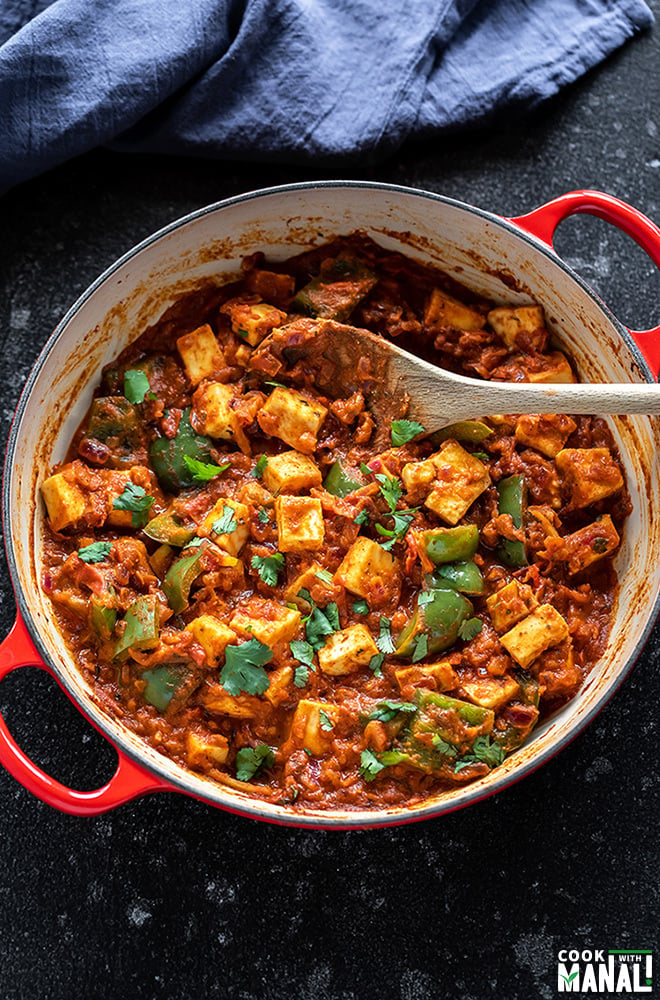

In [61]:
# request image from url
image_url = "https://www.cookwithmanali.com/wp-content/uploads/2017/03/Best-Kadai-Paneer.jpg"
response = requests.get(image_url)
## open image
image = Image.open(BytesIO(response.content))

## display image
from IPython.display import display
display(image)



In [62]:
## inference
pipe(image)

[{'label': 'kadai_paneer', 'score': 0.9888356328010559},
 {'label': 'pav_bhaji', 'score': 0.6803271770477295},
 {'label': 'chole_bhature', 'score': 0.5747055411338806},
 {'label': 'dal_makhani', 'score': 0.5314677357673645},
 {'label': 'pakode', 'score': 0.4889760911464691}]

Summary
* Aha! It predicted kadai_paneer successfully.

# Summary
* We were able to fine tune the vision transformer model on a specific indian food dataset.
* However, there are multiple types of data augmentation techniques that would be worth trying to account for variations in food images that are encountered on real world data which would make the classification model more robust.